# <font color='darkblue'> Sparkify Stacking Models</font>

<div class="alert alert-block alert-info">

This notebook is dedicated to the task of creating a stacking model based on individual classifiers available in PySpark. 
    <li> split the data in train, validation and test sets</li>
    <li> train each of the classifiers on the train set</li>
    <li> have each classifier make predictions on the validation set</li>
    <li> create a meta-features dataset from the individual predictions</li>
    <li> train a linear regression classifier on the meta-features dataset</li>
    <li> evaluate the full model on the test set</li>
</div>

## <font color='blue'>Build the Workspace</font>

In [1]:
# import PySpark libraries and packages

import pyspark
from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.sql import SparkSession
from pyspark.sql.window import Window as W

from pyspark.sql.types import (
    StringType,
    IntegerType, 
    DateType, 
    TimestampType,
    )

from pyspark.sql.functions import (
    min as Fmin, max as Fmax, 
    sum as Fsum, round as Fround, 
    
    col, lit, 
    first, last, 
    desc, asc,
    avg, count, countDistinct, 
    when, isnull, isnan,
    from_unixtime, 
    datediff,
    )

# libraries and packages for modeling

from pyspark.ml import Pipeline

from pyspark.ml.feature import (
    StringIndexer, 
    OneHotEncoder, 
    VectorAssembler, 
    StandardScaler
)
from pyspark.ml.feature import (
    OneHotEncoder, 
    OneHotEncoderModel
)

from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier,
    MultilayerPerceptronClassifier,
    LinearSVC,
    NaiveBayes
)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# build a Spark session using the SparkSession APIs

spark = (SparkSession
        .builder
        .appName("Sparkify")
        .getOrCreate())

#spark.sparkContext.setLogLevel("ERROR")

In [4]:
# import python libraries

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import sklearn metrics related packages

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve, roc_auc_score

# import library for enhanced plotting

import seaborn as sns
sns.set_style("darkgrid")
colors = sns.color_palette('PuBuGn_r')

## <font color="blue">Load, Preprocess and Split Data Functions</font>

In [5]:
def load_data(file_path):
    """
    Loads the raw dataset in Spark.
    
    INPUT:
            (str) - path for datafile
    OUTPUT:
            (PySpark dataframe) - dataframe of raw data
    
    """
    
    print("Loading the dataset ...")
    df = spark.read.json(file_path)
    print("Dataset is loaded...")
    
    return df

    
def clean_data(df):
    """
    Performs basic cleaning operations on the raw data:
        - removes entries with missing userId
        - rescale timestamp columns to seconds
        - drop unnecesary columns
            - personal information columns
            - song information columns
            - web and browser information
            - timestamp columns in miliseconds

    INPUT:
        (PySpark dataframe) - dataframe of raw data
    OUTPUT:
        (PySpark dataframe) - dataframe of cleaned data
    """

    # print message to indicate the start of the process
    print("Cleaning the data ...")

    # print a count of rows before cleaning
    initial_records = df.count()
    print("Dataset has {} rows initially.".format(initial_records))

    # remove all the records without userId
    df = df.where(df.userId != "")

    # rescale the timestamp to seconds (initially in miliseconds)
    df = df.withColumn("log_ts", df.ts/1000.0)
    df = df.withColumn("reg_ts", df.registration/1000.0)

    # drop several unnecessary columns
    cols_to_drop = ("firstName", "lastName", "location",
                    "artist", "song", "length",
                    "userAgent", "method", "status",
                    "ts", "registration"
                   )
    df = df.drop(*cols_to_drop)


    # print end of process message
    print("Finished cleaning the data ...")

    # print a count of rows after cleaning
    removed_rows = initial_records - df.count()

    print("Cleaned dataset has {} rows, {} rows were removed". \
        format(df.count(), initial_records - df.count()))

    return df


def preprocess_data(df):

    """
    Prepare the data for modeling via creating several features.

        - reg_date (date) - month-year of the registration

        - create windows grouped on userId and sessionId

         - firstevent_ts (timestamp) - first time an user is active
         - lastevent_ts (timestamp) - last time an user is active

         - init_days_interv (float) - days between registration and first activity
         - tenure_days_interv (float) - days between registration and last activity
         - active_days (float) - days the user has some activity on the platform
         - session_h (float) - session's duration in hours

     INPUT:
         df (PySpark dataframe) - cleaned dataframe
     OUTPUT:
         df (PySpark dataframe) - dataframe with the listed features added
    """

    # extract registration month and year from timestamp
    df = df.withColumn("reg_date", from_unixtime(col("reg_ts"), "MM-yyyy"))

    # create window: data grouped by userId, time ordered
    win_user = (W.partitionBy("userId")
            .orderBy("log_ts")
            .rangeBetween(W.unboundedPreceding,
                          W.unboundedFollowing))

    # create window: data grouped by sessionId and userId, time ordered
    win_user_session = (W.partitionBy("sessionId", "userId")
                        .orderBy("log_ts")
                        .rangeBetween(W.unboundedPreceding,
                                      W.unboundedFollowing))

    # record the first time an user is active
    df = df.withColumn("firstevent_ts", first(col("log_ts")).over(win_user))
    # record the last time an user is active
    df = df.withColumn("lastevent_ts", last(col("log_ts")).over(win_user))

    # warmup time = registration time to first event in days
    df = df.withColumn("init_days_interv",
                       (col("firstevent_ts").cast("long")-col("reg_ts").cast("long"))/(24*3600))

    # tenure time = registration time to last event in days
    df = df.withColumn("tenure_days_interv",
                       (col("lastevent_ts").cast("long")-col("reg_ts").cast("long"))/(24*3600))

    # active time =  days between the first event and the last event in days
    df = df.withColumn("active_days",
                       (col("lastevent_ts").cast("long")-col("firstevent_ts").cast("long"))/(24*3600))

    # create column that records the individual session's duration in hours
    df = df.withColumn("session_h",
                    (last(df.log_ts).over(win_user_session) \
                     - first(df.log_ts).over(win_user_session))/3600)

    # drop columns
    df = df.drop("reg_ts", "log_ts")

    return df


def build_features(df):

    """
    Features engineered to be used in modelling.

        - nr_songs (int) - total number of songs user listened to
        - nr_playlist (int) - number of songs added to the playlist

        - nr_friends (int) - number of friends added through "Add Friend"

        - nr_likes (int) - total number of "Thumbs Up" of the user
        - nr_dislikes (int) - total number of "Thumbs Down" of the user

        - nr_downgrades (int) - total number of visits to "Downgrade" page by the user
        - nr_upgrades (int) - total number of visits to "Upgrade" page by the user

        - nr_home (int) - total number of visits to "Home" page by the user
        - nr_settings (int) - total number of visits to "Settings" page by the user

        - nr_error (int) - total number of errors encountered by the user

        - nr_ads (int) - total number of ads the user got
        - nr_sessions (int) - number of sessions of the user
        - n_acts (int) - total number of actions taken by the user

        - avg_sess_h (float) - average session length in hours
        - acts_per_session (float) - average number of actions per session for the user
        - songs_per_session (float) - average numer of songs listened per session by the user
        - ads_per_session (float) - average number of ads per session, received by user

        - init_days_interv (int) - time interval in days from registration to the first action of the user
        - tenure_days_interv (int) - time interval in days from registration to the last action of the user
        - active_days (int) - number of days the user was active on the platform

        - gender (binary) - 1 for F (female), 0 for M (male)
        - level (binary) - 1 for paid, 0 for free

        - churn (binary) - 1 for "Cancellation Confirmation" page visit, 0 otherwise

    INPUT:
        df (PySpark dataframe) - preprocessed dataframe
    OUTPUT:
        df_feats (PySpark dataframe) - dataframe that contains engineered features
    """

    df_feats = df.groupBy("userId") \
        .agg(

            # count user's individual actions using all page visits

            count(when(col("page") == "NextSong", True)).alias("nr_songs"),
            count(when(col("page") == "Add to Playlist", True)).alias("nr_playlist"),

            count(when(col("page") == "Add Friend", True)).alias("nr_friends"),

            count(when(col("page") == "Thumbs Up", True)).alias("nr_likes"),                count(when(col("page") == "Thumbs Down", True)).alias("nr_dislikes"),

            count(when(col("page") == "Downgrade", True)).alias("nr_downgrades"),
            count(when(col("page") == "Upgrade", True)).alias("nr_upgrades"),

            count(when(col("page") == "Home", True)).alias("nr_home"),
            count(when(col("page") == "Settings", True)).alias("nr_settings"),

            count(when(col("page") == "Error", True)).alias("nr_error"),

            count(when(col("page") == "Roll Advert", True)).alias("nr_ads"),

            # compute the number of sessions a user is in
            countDistinct("sessionId").alias("nr_sessions"),

            # find the total number of actions a user took
            countDistinct("itemInSession").alias("n_acts"),

            # compute the average session length in hours
            avg(col("session_h")).alias("avg_sess_h"),

            # compute the average number of page actions per sesssion - i.e. items in session
            (countDistinct("itemInSession") /countDistinct("sessionId")).alias("acts_per_session"),

            # compute the average number of songs per session
            (count(when(col("page") == "NextSong", True)) /countDistinct("sessionId")).alias("songs_per_session"),

            # compute the average number of ads per session
             (count(when(col("page") == "Roll Advert", True)) /countDistinct("sessionId")).alias("ads_per_session"),

            # days between registration and first activity
            first(col("init_days_interv")).alias("init_days_interv"),
            # the tenure time on the platform: from registration to last event in days
            first(col("tenure_days_interv")).alias("tenure_days_interv"),
            # number of days user visited the platform, is active on the platform
            first(col("active_days")).alias("active_days"),

            # encode the gender 1 for F and 0 for M
            first(when(col("gender") == "F", 1).otherwise(0)).alias("gender"),

            # encode the level (paid/free) according to the last record
            last(when(col("level") == "paid", 1).otherwise(0)).alias("level"),

            # flag those users that downgraded
            #last(when(col("page") == "Downgrade", 1).otherwise(0)).alias("downgrade"),

            # create the churn column that records if the user cancelled
            last(when(col("page") == "Cancellation Confirmation", 1).otherwise(0)).alias("churn"),
            )

    # columns to drop
    drop_cols = ("userId", "gender", "avg_sess_h",
                 "nr_playlist", "nr_home")
    # drop the columns
    #df_feats = df_feats.drop("userId")
    df_feats = df_feats.drop(*drop_cols)

    # drop the null values
    df_feats=df_feats.na.drop()

    return df_feats

In [6]:
def split_data (df):

    """
    Split the dataset into training, validation set and test set.
    Use a stratified sampling method.

    INPUT:
        df (PySpark dataframe) - dataframe
    OUTPUT:
        train_set, validation_set, test_set (PySpark dataframes) - 
                          percentage split based on the provided values
    """

    # split dataframes between 0s and 1s
    zeros = df.filter(df["churn"]==0)
    ones = df.filter(df["churn"]==1)

    # split dataframes into training and testing
    train0, validation0, test0 = zeros.randomSplit(SPLIT_VALS, seed=1234)
    train1, validation1, test1 = ones.randomSplit(SPLIT_VALS, seed=1234)

    # stack datasets back together
    train_set = train0.union(train1)
    validation_set = validation0.union(validation1)
    test_set = test0.union(test1)

    return train_set, validation_set, test_set

In [7]:
def prepare_data(dataset_filepath):
    
    """
    Function that combines all the data preparation steps.
    
    INPUT:
        dataset_filepath (str) - filepath for raw data json file
    OUTPUT:
       train_set, validation_set, test_set (PySpark dataframes) - 
            subsets of the features dataset
    """
    
    print('Load data...')
    df = load_data(dataset_filepath)
    
    print('Clean data...')
    df_clean = clean_data(df)
    
    print('Preprocess data...')
    df_proc = preprocess_data(df_clean)
    
    print('Create features dataset...')
    df_feats = build_features(df_proc)
    
    print('Split the features dataset...')
    train_set, validation_set, test_set = split_data(df_feats)
    
    return train_set, validation_set, test_set

## <font color="blue">Model Evaluators Functions</font>

In [36]:
# function to compute relevant metrics for binary classification
def conf_metrics(dataset):
    
    """
        Calculates the metrics associated to the confusion matrix.

        INPUT:
            dataset (pyspark.sql.DataFrame) - a dataset that contains
                                labels and predictions
        OUTPUT:
            accuracy (float) - metric
            precision (float) - metric
            recall (float) - metric
            F1 (float) - metric
    """
   

    # calculate the elements of the confusion matrix
    tn = dataset.where((dataset[meta_labelCol]==0) & (dataset[meta_predCol]==0)).count()
    tp = dataset.where((dataset[meta_labelCol]==1) & (dataset[meta_predCol]==1)).count()                   
    fn = dataset.where((dataset[meta_labelCol]==1) & (dataset[meta_predCol]==0)).count()                   
    fp = dataset.where((dataset[meta_labelCol]==0) & (dataset[meta_predCol]==1)).count()
    
    # calculate accuracy, precision, recall, and F1-score
    accuracy = (tn + tp) / (tn + tp + fn + fp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 =  2 * (precision*recall) / (precision + recall)
    
    return accuracy, precision, recall, f1

# function to display the metrics of interest
def display_metrics(dataset, roc_cl, pr_cl):
    
    """
    Prints evaluation metrics for the model. 
    
    INPUT:
         dataset (pyspark.sql.DataFrame) - a dataset that contains
                                labels and predictions
        roc_cl, pr_cl (float) - ROC and PR scores for the evaluate classifier cl
    OUTPUT:
        none - table of metrics are displayed
    
    """
    
    accuracy = conf_metrics(dataset)[0]
    precision = conf_metrics(dataset)[1]
    recall = conf_metrics(dataset)[2]
    f1 = conf_metrics(dataset)[3]
    
    print("")
    print("Confusion Matrix")
    dataset.groupBy(dataset[meta_labelCol], dataset[meta_predCol]).count().show()
    print("")
    print("accuracy...............%6.3f" % accuracy)
    print("precision..............%6.3f" % precision)
    print("recall.................%6.3f" % recall)
    print("F1.....................%6.3f" % f1)
    print("auc_roc................%6.3f" % roc_cl)
    print("auc_pr.................%6.3f" % pr_cl)

# function to plot the roc and pr curves side by side (uses Pandas)
def plot_roc_pr_curves(predictions, model_name):
    
    """
    Calculates ROC-AUC and PR-AUC scores and plots the ROC and PR curves.
    
    INPUT:
        predictions (PySpark dataframe) - contains probability predictions, label column
        model_name (str) - classifier name
        
    OUTPUT:
        none - two plots are displayed
        
    """
    
    # transform predictions PySpark dataframe into Pandas dataframe
    pred_pandas = predictions.select(predictions.label, predictions.probability).toPandas()
    
    # calculate roc_auc score
    roc_auc = roc_auc_score(pred_pandas.label, pred_pandas.probability.str[1])
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(pred_pandas.label))]
    # calculate roc curves
    fpr, tpr, _ = roc_curve(pred_pandas.label, pred_pandas.probability.str[1])
    ns_fpr, ns_tpr, _ = roc_curve(pred_pandas.label, ns_probs)
    
    # calculate precision, recall for each threshold
    precision, recall, _ = precision_recall_curve(pred_pandas.label, pred_pandas.probability.str[1])
    # calculate pr auc score
    pr_auc = auc(recall, precision)
    
    # create figure which contains two subplots
    plt.figure(figsize=[12,6])
    
    plt.subplot(121)
    
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', color="firebrick", label='ROC AUC = %.3f' % (roc_auc))
    
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # figure title
    plt.title("ROC Curve:" + model_name)
    
    plt.subplot(122)
    
    # plot the precision-recall curves
    
    ns_line = len(pred_pandas[pred_pandas.label==1]) / len(pred_pandas.label)
    plt.plot([0, 1], [ns_line, ns_line], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', color="firebrick", label='PR AUC = %.3f' % (pr_auc))
    
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    # figure title
    plt.title("Precision-Recall Curve:" + model_name)

## <font color="blue">Build Pipelines and Instantiate Models</font>

In [9]:
# define the base models
# use different labels for the prediction columns to avoid overlap when stacking

lr = LogisticRegression(featuresCol='features', labelCol='label', 
                        predictionCol='pred_lr', probabilityCol='prob_lr',
                        rawPredictionCol='rawPred_lr')

rf = RandomForestClassifier(featuresCol='features', labelCol='label', 
                  predictionCol='pred_rf', probabilityCol='prob_rf', 
                  rawPredictionCol='rawPred_rf')

gbt = GBTClassifier(featuresCol='features', labelCol='label',
                    predictionCol='pred_gbt', probabilityCol='prob_gbt', 
                    rawPredictionCol='rawPred_gbt')

layers=[18,8,4,2]
mlpc= MultilayerPerceptronClassifier(featuresCol='features', labelCol='label',
                                     predictionCol='pred_mlpc', probabilityCol='prob_mlpc',
                                     rawPredictionCol='rawPred_mlpc', layers=layers)

lsvc = LinearSVC(featuresCol='features', labelCol='label', 
                predictionCol='pred_lsvc', rawPredictionCol='rawPred_lsvc')

models = [lr, rf, gbt, mlpc, lsvc]

In [24]:
# split the features and the label
CAT_FEATURES = ["level"]
CONT_FEATURES = ["nr_songs", "nr_likes", "nr_dislikes", "nr_friends", "nr_downgrades",
                "nr_upgrades", "nr_error", "nr_settings", "nr_ads", "nr_sessions",
                "n_acts", "acts_per_session", "songs_per_session", "ads_per_session",
                "init_days_interv", "tenure_days_interv", "active_days"]
CHURN_LABEL = "churn"

def build_data_pipeline():
    """
    Combines all the stages of the data processing.
    """
    # stages in the pipeline
    stages = [] 
    
    # encode the labels
    label_indexer =  StringIndexer(inputCol=CHURN_LABEL, outputCol="label")
    stages += [label_indexer]
    
    # encode the binary features
    bin_assembler = VectorAssembler(inputCols=CAT_FEATURES, outputCol="bin_features")
    stages += [bin_assembler]
    
    # encode the continuous features
    cont_assembler = VectorAssembler(inputCols = CONT_FEATURES, outputCol="cont_features")
    stages += [cont_assembler]
    # normalize the continuous features
    cont_scaler = StandardScaler(inputCol="cont_features", outputCol="cont_scaler", 
                                 withStd=True , withMean=True)
    stages += [cont_scaler]
    
    # pass all to the vector assembler to create a single sparse vector
    all_assembler = VectorAssembler(inputCols=["bin_features", "cont_scaler"],  
                            outputCol="features")
    stages += [all_assembler]
    
    # add the models to the pipeline
    stages += models
    
    # create a pipeline
    pipeline = Pipeline(stages=stages)
    
    return pipeline

In [25]:
# prepare the meta_features for modeling

# split the features and the label
META_FEATURES = ["pred_lr", "pred_rf","pred_gbt", "pred_mlpc", "pred_lsvc"]
META_CONT_FEATURES = ["prob_lr", "prob_rf", "prob_mlpc"]
META_LABEL_COL = "label"

# create labels and features
meta_predCol="meta_prediction"
meta_labelCol="meta_label"
meta_featuresCol = "meta_features"

def build_meta_pipeline(meta_classifier):
    """
    Combines all the stages of the meta features processing.
    """
    # stages in the pipeline
    stages = [] 
    
    # encode the labels
    label_indexer =  StringIndexer(inputCol=META_LABEL_COL, outputCol="meta_label")
    stages += [label_indexer]
    
    # encode the binary features
    bin_assembler = VectorAssembler(inputCols=META_FEATURES, outputCol="bin_features")
    stages += [bin_assembler]
    
    # encode the continuous features
    cont_assembler = VectorAssembler(inputCols = META_CONT_FEATURES, outputCol="cont_features")
    stages += [cont_assembler]
    # normalize the continuous features
    cont_scaler = StandardScaler(inputCol="cont_features", outputCol="cont_scaler", 
                                 withStd=True , withMean=True)
    stages += [cont_scaler]
    
    # pass all to the vector assembler to create a single sparse vector
    all_assembler = VectorAssembler(inputCols=["bin_features", "cont_scaler"],  
                                    outputCol="meta_features")
    stages += [all_assembler]
    
    # add the models to the pipeline
    stages += [meta_classifier]
    
    # create a pipeline
    pipeline = Pipeline(stages=stages)

    return pipeline

# implement K-fold cross validation and grid search 
def grid_search_model(pipeline, paramGrid):
    """
    Creates a cross validation object and performs grid search
    over a set of parameters.
    
    INPUT:
        param = grid of parameters
        pipeline = model pipeline 
    
    OUTPUT:
        cv = cross validation object
    """
    
    # choose an evaluator
    evaluator = BinaryClassificationEvaluator()
    evaluator.setLabelCol(meta_labelCol)
    
    # create the cross-validation object
    cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5,
                    parallelism=2)
    return cv

## <font color="blue">Process and Model Base Classifiers</font>

In [12]:
SPLIT_VALS = [.4, .3, .3]   

# path for the test set file file

path_dataset = "data/mini_sparkify_event_data.json"
#path_dataset = "data/full_sparkify_event_data.json"

In [13]:
# clean, process and split the data
train_df, validation_df, test_df = prepare_data(path_dataset)

Load data...
Loading the dataset ...


Dataset is loaded...
Clean data...
Cleaning the data ...
Dataset has 286500 rows initially.
Finished cleaning the data ...
Cleaned dataset has 278154 rows, 8346 rows were removed
Preprocess data...
Create features dataset...
Split the features dataset...


In [14]:
# save the data in the memory and disk
train_cached = train_df.persist()
validation_cached = validation_df.persist()
test_cached = test_df.persist()

22/02/08 21:36:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [15]:
# instantiate the data pipeline to process data
base_pipeline = build_data_pipeline()

# start timer
start_time = time.time()

# fit the pipeline on the transformed train set
base_pipeline_model = base_pipeline.fit(train_cached)

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time 
print("")
print("Training time.........%6.3f min" % train_time)

22/02/08 21:36:33 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/02/08 21:36:33 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/02/08 21:38:52 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.5
22/02/08 21:38:52 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.25
22/02/08 21:38:53 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.125
22/02/08 21:38:53 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.0625
22/02/08 21:38:53 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.03125
22/02/08 21:38:54 ERROR StrongWolfeLineSearch: Encountered bad values in function evaluation. Decreasing step size to 0.015625
22/02/08 21:38:54 ERROR StrongWolfeLineSea


Training time......... 4.391 min


In [16]:
# make predictions on the validation set
base_pred = base_pipeline_model.transform(validation_cached)

In [17]:
# take a look at the base_pred dataframe structure
base_pred.printSchema()

root
 |-- nr_songs: long (nullable = false)
 |-- nr_friends: long (nullable = false)
 |-- nr_likes: long (nullable = false)
 |-- nr_dislikes: long (nullable = false)
 |-- nr_downgrades: long (nullable = false)
 |-- nr_upgrades: long (nullable = false)
 |-- nr_settings: long (nullable = false)
 |-- nr_error: long (nullable = false)
 |-- nr_ads: long (nullable = false)
 |-- nr_sessions: long (nullable = false)
 |-- n_acts: long (nullable = false)
 |-- acts_per_session: double (nullable = true)
 |-- songs_per_session: double (nullable = true)
 |-- ads_per_session: double (nullable = true)
 |-- init_days_interv: double (nullable = true)
 |-- tenure_days_interv: double (nullable = true)
 |-- active_days: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- label: double (nullable = false)
 |-- bin_features: vector (nullable = true)
 |-- cont_features: vector (nullable = true)
 |-- cont_scaler: vector (nullable = true)
 |-- features: vecto

### <font color="blue">Toggle the Memory</font>

In [18]:
# remove the raw datasets from memory
train_cached.unpersist()
validation_cached.unpersist()

DataFrame[nr_songs: bigint, nr_friends: bigint, nr_likes: bigint, nr_dislikes: bigint, nr_downgrades: bigint, nr_upgrades: bigint, nr_settings: bigint, nr_error: bigint, nr_ads: bigint, nr_sessions: bigint, n_acts: bigint, acts_per_session: double, songs_per_session: double, ads_per_session: double, init_days_interv: double, tenure_days_interv: double, active_days: double, level: int, churn: int]

## <font color="blue">The Metaclassifier</font>

In [19]:
# create the meta features dataset
meta_features_df = base_pred.select("pred_lr", "pred_rf", "pred_gbt", 
                                    "pred_mlpc","pred_lsvc",
                                    "prob_lr", "prob_rf", "prob_mlpc", "prob_gbt",
                                    "label")

In [26]:
print("")
print(f"Training LOGISTIC REGRESSION META CLASSIFIER")
print("")

# instantiate the classifier
meta_classifier = LogisticRegression(featuresCol=meta_featuresCol, 
                             labelCol=meta_labelCol, 
                             predictionCol=meta_predCol)

# build specific pipeline
meta_pipeline = build_meta_pipeline(meta_classifier)

# create the parameters list
meta_param = ParamGridBuilder() \
        .addGrid(meta_classifier.regParam, [0.0, 0.01, 0.1]) \
        .addGrid(meta_classifier.elasticNetParam, [0.0, 0.01, 0.1]) \
        .addGrid(meta_classifier.maxIter, [50, 100, 200]) \
        .build()


# build the grid search model
meta_lr = grid_search_model(meta_pipeline, meta_param)

# start timer
start_time = time.time()

# train the model
meta_model = meta_lr.fit(meta_features_df.persist())

# stop timer
end_time = time.time()

# evaluate the trainining time in minutes 
train_time = (end_time - start_time)/60

# print the training time
print("")
print("Training time.........%6.3f min" % train_time)


Training LOGISTIC REGRESSION META CLASSIFIER



22/02/08 21:55:26 WARN BlockManager: Asked to remove block broadcast_4334, which does not exist
22/02/08 21:56:52 WARN BlockManager: Asked to remove block broadcast_4668_piece0, which does not exist
22/02/08 21:56:52 WARN BlockManager: Asked to remove block broadcast_4668, which does not exist
22/02/08 22:02:40 WARN BlockManager: Asked to remove block broadcast_5998_piece0, which does not exist
22/02/08 22:03:56 WARN BlockManager: Asked to remove block broadcast_6279, which does not exist
22/02/08 22:14:10 WARN BlockManager: Asked to remove block broadcast_8605, which does not exist
22/02/08 22:14:10 WARN BlockManager: Asked to remove block broadcast_8605_piece0, which does not exist



Training time.........52.543 min


In [27]:
# base classifiers make predictions on the test set
test_pred = base_pipeline_model.transform(test_cached)

In [29]:
# create the meta features test dataset
meta_test_df = test_pred.select("pred_lr", "pred_rf", "pred_gbt", 
                                    "pred_mlpc","pred_lsvc",
                                    "prob_lr", "prob_rf", "prob_mlpc", "prob_gbt",
                                    "label")

In [30]:
# meta classifier predictions on the meta features test set
meta_test_pred = meta_model.transform(meta_test_df)

In [34]:
# choose an evaluator
evaluator = BinaryClassificationEvaluator()
evaluator.setLabelCol(meta_labelCol)

# calculate roc and pr scores
roc_meta = evaluator.evaluate(meta_test_pred, {evaluator.metricName: "areaUnderROC"})
pr_meta = evaluator.evaluate(meta_test_pred, {evaluator.metricName: "areaUnderPR"})

# record the confusion matrix metrics on the test set
acc_meta, prec_meta, rec_meta, f1_meta = conf_metrics(meta_test_pred)

In [37]:
# print all evaluation metrics
print("")
display_metrics(meta_test_pred, roc_meta, pr_meta)
print("")


Confusion Matrix


+----------+---------------+-----+
|meta_label|meta_prediction|count|
+----------+---------------+-----+
|       1.0|            1.0|    9|
|       0.0|            1.0|    3|
|       1.0|            0.0|    3|
|       0.0|            0.0|   43|
+----------+---------------+-----+


accuracy............... 0.897
precision.............. 0.750
recall................. 0.750
F1..................... 0.750
auc_roc................ 0.887
auc_pr................. 0.845



In [38]:
# print the best parameters from the grid
best_meta_param = list(meta_model.getEstimatorParamMaps()[np.argmax(meta_model.avgMetrics)].values())
meta_param1 = best_meta_param[0]
meta_param2 = best_meta_param[1]
meta_param3 = best_meta_param[2]
print("The best hyperparameter values from the grid:")
print("regParam:..................", meta_param1)
print("elasticNetParam:...........", meta_param2)
print("maxIter:...................", meta_param3)

The best hyperparameter values from the grid:
regParam:.................. 0.01
elasticNetParam:........... 0.0
maxIter:................... 50


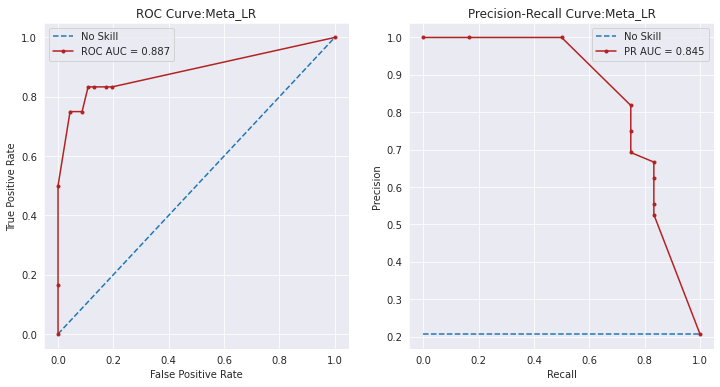

In [39]:
# plot the ROC and PR curves
plot_roc_pr_curves(meta_test_pred, "Meta_LR")